In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats.stats as stats
import re
import math
from datetime import datetime
import importlib
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, RidgeClassifierCV
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold, GridSearchCV 
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, f1_score, confusion_matrix, precision_score, recall_score, classification_report;
import time

import statsmodels.api as sm

In [2]:
# !pip install mlxtend
# !pip install lightgbm
# !pip install tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from autoscoring.AS import *
from autoscoring.AS_2 import *
from autoscoring.Binning import transform_df_to_woe, construction_binning, create_num_intervals, create_dict_cat_feats

In [5]:
path = 'data/'
df = pd.read_excel(path + 'final_dataset.xlsx')

df['date_requested'] = pd.to_datetime(df['date_requested'])
DATE = 'date_requested'  # Дата, по которой аггрегировать и оценивать gini/psi и т.д. по дефолту дата выдачи.
df[DATE] = pd.to_datetime(df[DATE])

In [6]:
df = df[df['date_requested']>= '2022-11-01']

In [7]:
# Проверяем каждую колонку на количество уникальных значений
columns_to_drop = []
for column in df.columns:
    if df[column].nunique() <= 1:
        columns_to_drop.append(column)

# Удаляем колонки с одним уникальным значением
print("Кол-во признаков на удаление: ", len(columns_to_drop))
print("Название признаков на удаление: ", columns_to_drop)

Кол-во признаков на удаление:  99
Название признаков на удаление:  ['act_now_div_frst_cr', 'all_now_div_frst_cr', 'mnt_inst_owner_div_frst_cr', 'mnt_outstand_balance_div_frst_cr', 'exists_income_for_6_month', 'cnt_PDL_exp', 'sum_PDL_credit_sum', 'min_PDL_planned_close_date', 'cnt_PDL_past_due', 'cnt_PDL_exp_no_Crd', 'sum_PDL_credit_sum_no_Crd', 'cnt_PDL_past_due_no_Crd', 'payments_loans', 'response_code', 'io_device_type', 'io_device_os', 'io_device_browser_type', 'score_4_9', 'rec_ratio_3m_90', 'money_out_3m_90', 'money_overdue_3m_90', 'money_out_ratio_3m_90', 'money_out_ratio_6m_90', 'cnt_rej_blacklist', 'cnt_rej_coff_new_s8_clientrefused', 'score_1_1_division_score_1_1', 'score_1_2_division_score_1_2', 'score_1_3_division_score_1_3', 'score_1_4_division_score_1_4', 'score_1_5_division_score_1_5', 'score_1_6_division_score_1_6', 'score_1_7_division_score_1_7', 'score_1_8_division_score_1_8', 'score_1_9_division_score_1_9', 'score_1_10_division_score_1_10', 'score_2_1_division_score_2

In [8]:
# Удаляем лишние колонки, конкретный набор зависит от сэмпла.
cols_to_drop = [var for var in df.columns if 'scoring_' in var]
print('Кол-во признаков на удаление: ', len(cols_to_drop))
print('Название признаков: ', cols_to_drop)
df.drop(cols_to_drop, axis=1, inplace=True)

Кол-во признаков на удаление:  0
Название признаков:  []


In [9]:
# # В некоторых случаях при загрузке из excel файла может произойти проблема,
# # связанная с тем, что в excel вещественные числа разделяются запятой,
# # а в python разделение идёт по точке.
# # Если возникла такая проблема, то можно заменить все запятые на точки и сделать преобразование типовю

# # Запускать эту ячейку, только если есть данная проблема. Иначе можно пропустить.
# '''
# Запускать эту ячейку, только если есть данная проблема c приведением типво данных.
# Иначе можно пропустить.

# '''
# for col in df.select_dtypes(include=object).columns:
#     if col == DATE:
#         continue
#     df[col] = df[col].apply(lambda x: str(x).replace(',', '.'))

# df = df.apply(pd.to_numeric, errors='ignore')
# df[DATE] = pd.to_datetime(df[DATE], format='%Y-%m-%d')
# df = df.replace('nan', np.nan)

In [10]:
# задание названия переменной, являющейся таргетом
TARGET = 'npl1_1_7dpd'
df = df[df[TARGET].isna() == False]

# # Фильтрация требуемого сегмента
# df = df[(df['product_group'] == 'MICRO_SELF_EMPLOYED')]

df['target'] = df[TARGET]
y = df[TARGET]

In [11]:
# Filling missing values (np.nan, '_MISSING_')
cat_vars = df.select_dtypes(include=[object]).columns
df = filling(df)

min_num = 50
# Можно задать список признаков, который не будет учавствовать в предобработке
ignore_vars = ['date_requested', 'credit_id', 'target', DATE,'npl1_1_7dpd']
df, else_df = replace_not_frequent_2(df, cat_vars, num_min=min_num, ignore_vars=ignore_vars)

# Drop columns with only 1 value
df = drop_single_value_column(df, except_cols=ignore_vars)

In [12]:
# # Удаляем лишние колонки, конкретный набор зависит от сэмпла.
# cols_to_drop = [var for var in df.columns if 'SCOR' in var or 'street' in var or 'scoring' in var]
# df.drop(cols_to_drop, axis=1, inplace=True)

#### Построение WOE таблицы

In [13]:
# # Задаём набор признаков для формирования биннинга.
# # Набор колонок, который не будет учавствовать в построении карты
# technical_features = ['credit_id',
#                       'date_requested', 'target', 'npl1_1_7dpd', DATE]
# technical_features = list(set(technical_features))
# # Задаём набор признаков, которые будут учавствовать в биннинге,
# # для этого удаляем все ненужные признаки из общего списка переменных.
# features = df.drop(
#     technical_features
# , axis=1).columns

# target_name = 'target'  # Наименование столбца - таргета
# # Минимальное количество объектов в бине, по дефолту 0.05, требуется менять
# # только в исключительных ситуациях
# min_bin_size = 0.05
# max_bin_count = 5  # Максимальное количество бинов при разбиении, по дефолту 5 - хороший вариант.
# # Как определять WOE для пропусков, если их меньше чем min_bin_size:
# # max - максимальное WOE
# # max_cat - WOE самой крупной группы, можно оставить это по дефолту
# # min - минимальное WOE
# # zero - значение WOE становится 0
# nan_to_woe = 'max_cat'
# # Как определять WOE для _ELSE_ значений, если их меньше чем min_bin_size:
# # max - максимальное WOE
# # max_cat - WOE самой крупной группы, можно оставить это по дефолту
# # min - минимальное WOE
# # zero - значение WOE становится 0
# else_to_woe = 'max_cat'
# # Если True, то специально накладываются ограничения, чтобы WOE был монотонным по бинам,
# # лучше оставить False, и потом в ручном режиме поменять, если не требуется обратного.
# monotonic = False
# n_jobs = 4  # Количество ядер для работы, чем больше тем быстрее, по дефолту 4.

# iv_df, dropped_feats, feats, best_features, auto_woe = construction_binning(df, features, target_name,
#                                                          max_bin_count=max_bin_count,
#                                                          min_bin_size=min_bin_size,
#                                                          nan_to_woe=nan_to_woe,
#                                                          else_to_woe=else_to_woe,
#                                                          monotonic=monotonic,
#                                                          n_jobs=n_jobs)

# # iv_df - таблицы WOE биннинга
# # dropped_feats - набор переменных, для которых биннинг не посчитался,
# # т.к. в переменной не нашлось сколько-нибудь хорошего разделения или признак практически константный
# # feats - таблица полученная после предварительного отбора признаков, в которой указаны причины,
# # по которым признак не очень хороший, можно игнорировать
# # best_features - набор признаков после предварительного отбора внутри AutoML,
# # можно использовать при дальнейшем отборе, можно проигнорировать
# # auto_woe - техническая переменная, можно игнорировать

In [14]:
iv_df = pd.read_excel('result/iv_df_new_data_2023.xlsx')

### Вначале сделаем отбор переменных, далее будет подготовка признаков и построения дерева решений.

In [ ]:
# Набор обязательных признаков (для примера), которые должны остаться несмотря на отбор.
# Разкомментировать, если он нужен.

# mandatory_feats = ['credits_active_owner', 'credits_all_owner']
# mandatory_feats_woe = ['WOE_' + col for col in mandatory_feats]

In [ ]:
# Порог для фильтрации по IV.
# Требуется устанавливать в зависимости от количества признаков, но лучше сильно не ограничивать.
# Например если признаков меньше 200, то можно поставить iv_co = 0.01 или 0.02.
# Иначе можно поставить iv_co = 0.03 - 0.05.
iv_co = 0.05
features_iv = iv_df[iv_df['IV'] > iv_co]['VAR_NAME'].unique()
print(len(features_iv))

# Добавялем к списку обязательные переменные, если требуется
# vars = add_mandatory_feats(vars, mandatory_feats)

IV = iv_df[['VAR_NAME', 'IV']].drop_duplicates()
IV = IV[IV['VAR_NAME'].isin(features_iv)]

5167


In [ ]:
IV.to_pickle('pickle/IV.pkl')

In [15]:
IV = pd.read_pickle('pickle/IV.pkl')

In [ ]:
# Данные подготовка нужна, чтобы быстрее сделать преобразование
iv_df = create_num_intervals(iv_df)
dict_cat_feats = create_dict_cat_feats(iv_df)

iv_co = None
X, y = transform_df_to_woe(df[features_iv], y, IV, iv_df, dict_cat_feats, iv_cut_off=iv_co, n_jobs=4)

Features left after IV drop: 5167
score_1_1_division_score_2_2 - ERROR! Column was dropped!, Exception
score_1_1_division_score_2_3 - ERROR! Column was dropped!, Exception
score_1_1_division_score_6_1 - ERROR! Column was dropped!, Exception
score_1_1_division_score_6_2 - ERROR! Column was dropped!, Exception
score_1_1_division_score_6_3 - ERROR! Column was dropped!, Exception
score_1_1_division_score_7_1 - ERROR! Column was dropped!, Exception
score_1_1_division_score_7_2 - ERROR! Column was dropped!, Exception
score_1_1_division_score_7_3 - ERROR! Column was dropped!, Exception
score_1_1_division_mail_score_round - ERROR! Column was dropped!, Exception
score_1_2_division_score_2_2 - ERROR! Column was dropped!, Exception
score_1_2_division_score_2_3 - ERROR! Column was dropped!, Exception
score_1_2_division_score_6_1 - ERROR! Column was dropped!, Exception
score_1_2_division_score_6_2 - ERROR! Column was dropped!, Exception
score_1_2_division_score_6_3 - ERROR! Column was dropped!, Exc

In [ ]:
# Устанавливаем порого для фильтрации признаков по корреляциям.
# По дефолту 0.85 - оптимальное значение, в зависимости от требований
# можно поставить число в диапозоне 0.75 - 0.9.
cut_off = 0.85
X_train_corr = delete_correlated_features(X, cut_off=cut_off, is_plot_prev=False,
                                          exclude=[], IV_sort=True, iv_df=iv_df)

Dropped columns: [] 

Features left after correlation check: 4709 

Not dropped columns: ['reapeted_app', 'credits_active_owner', 'monthly_instalments_owner_x', 'mnt_outstand_balance', 'his_w_pay_st_by_act_crd_sum', 'his_w_pay_st_by_cls_crd_days', 'his_w_pay_st_by_cls_crd_sum', 'act_div_all_crd', 'sum_per_cred', 'h_cl_sum_div_days', 'h_ac_sum_div_days', 'h_ac_sum_div_h_cl_sum', 'cur_ac_sum_div_h_cl_sum', 'fcb_last_open_d_cr_act', 'fcb_last_open_d_cr_all', 'fcb_first_cred_open', 'fcb_first_cred_open_act', 'fcb_last_closed', 'fcb_last_closed_IL_noCrd_volume', 'average_amount_opv', 'average_monthly_income', 'conf_income_per', 'exists_income_for_3_month', 'cnt_pdl_act', 'cnt_IL_comp', 'cnt_IL_act', 'sum_IL_credit_sum', 'sum_all_credit_sum', 'min_IL_planned_close_date', 'min_all_planned_close_date', 'cnt_pdl_act_no_Crd', 'cnt_IL_comp_no_Crd', 'cnt_IL_all_no_Crd', 'cnt_IL_exp_no_Crd', 'cnt_all_exp_no_Crd', 'sum_IL_credit_sum_no_Crd', 'sum_all_credit_sum_no_Crd', 'min_IL_planned_close_date_no

In [ ]:
X = X[X_train_corr.columns]
X.columns = 'WOE_' + X.columns

In [ ]:
X.to_pickle('pickle/X.pkl')
y.to_pickle('pickle/y.pkl')

In [16]:
X = pd.read_pickle('pickle/X.pkl')
y = pd.read_pickle('pickle/y.pkl')

In [17]:
# Фильтруем признаки по следующему принципу:
# для каждого признака делаем однофакторный расчёт gini на train выборке для каждого месяца
# в разбивке по DATE (обязательно должен присутствовать в df_train).
# После этого отфильтровываем признаки, для которых gini меньше чем gini_min
# для количества интервалов большего num_bad_intervals.
# Т.е. например, если gini_min=0.05 и num_bad_intervals=2, то если gini переменной больше 0.05 для всех месяцев, кроме одного - это ок. 
gini_min = 0.02  # 0.05 - по дефолту норм, можно взять в диапозоне 0.02 - 0.08 в зависимости от качества признаков.
num_bad_intervals = 2  # 2 месяца/недели по дефолту норм, можно взять 10-20% от общего количества месяцев в сэмпле.
date_name = DATE  # Дата, по которой делить на месяцы.
intervals = 'month'  # Интервалы времени для разбивки, month или week

gini_feats, df_gini_months = gini_month_selection(X, df, gini_min=gini_min,
                                                  num_bad_intervals=num_bad_intervals, date_name=date_name,
                                                  intervals=intervals)

In [18]:
# Отбираем признаки по их значимости во время построения Деревьев решений.
top_n = 50  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 45-80.
rf_feats, rf_imp = rf_feature_selection(X[gini_feats], y, top_n=top_n)

In [19]:
# Отбираем признаки исходя из permutations_importance.
# Подробнее: https://www.kaggle.com/dansbecker/permutation-importance
top_n = 35  # Количество лучшеих признаков, которые оставить. Можно брать в диапозоне 30-50.
tf_feats, tf_imp = permutation_two_forest_selection(X[rf_feats], y, top_n=top_n)

In [20]:
# Итоговый набор переменных, который будет учавтсовать в построении дерева.
vars = [var.replace('WOE_', '') for var in tf_feats]

In [ ]:
# Заново добавляем список обязательных признаков.
# vars = add_mandatory_feats(vars, mandatory_feats)

In [21]:
vars

['open_date_cnt_7d',
 'inst_own_3mnth',
 'score_1_9_*_score_4_19',
 'score_4_11_*_score_6_3',
 'score_1_3_*_score_2_3',
 'score_2_3_division_score_5_6',
 'fc_mail_score',
 'score_2_2_*_score_4_16',
 'score_3_2_division_score_8_1',
 'requested_credit_count_days',
 'capsTotalAmountL1m',
 'score_5_5_division_score_5_8',
 'score_3_9_division_score_5_1',
 'score_1_2_division_score_4_29',
 'score_3_3_division_score_8_2',
 'DTI_0',
 'score_1_6_*_score_1_10',
 'score_2_2_division_score_5_12',
 'score_1_9_*_score_4_3',
 'score_1_7_*_score_5_9',
 'score_4_27_division_score_5_6',
 'score_1_7_division_score_4_15',
 'score_5_4_division_score_5_8',
 'score_4_3_division_score_4_16',
 'score_3_8_*_score_4_2',
 'score_2_2_*_score_3_6',
 'score_5_10_*_score_7_1',
 'score_6_2_*_score_6_3',
 'score_3_4_*_score_4_5',
 'PTI_11',
 'score_1_1_*_score_4_4',
 'score_2_2_division_score_3_9',
 'h_cl_sum_div_days',
 'score_5_11_division_score_8_3',
 'score_2_3_division_score_5_5']

In [ ]:
vars = [
    'open_date_cnt_7d',
    'inst_own_3mnth',
    'score_1_9_*_score_4_19',
    'score_4_11_*_score_6_3',
    'score_1_3_*_score_2_3',
    'score_2_3_division_score_5_6',
    'fc_mail_score',
    'score_2_2_*_score_4_16',
    'score_3_2_division_score_8_1',
    'requested_credit_count_days',
    'capsTotalAmountL1m',
    'score_5_5_division_score_5_8',
    'score_3_9_division_score_5_1',
    'score_1_2_division_score_4_29',
    'score_3_3_division_score_8_2',
    'DTI_0',
    'score_1_6_*_score_1_10',
    'score_2_2_division_score_5_12',
    'score_1_9_*_score_4_3',
    'score_1_7_*_score_5_9',
    'score_4_27_division_score_5_6',
    'score_1_7_division_score_4_15',
    'score_5_4_division_score_5_8',
    'score_4_3_division_score_4_16',
    'score_3_8_*_score_4_2',
    'score_2_2_*_score_3_6',
    'score_5_10_*_score_7_1',
    'score_6_2_*_score_6_3',
    'score_3_4_*_score_4_5',
    'PTI_11',
    'score_1_1_*_score_4_4',
    'score_2_2_division_score_3_9',
    'h_cl_sum_div_days',
    'score_5_11_division_score_8_3',
    'score_2_3_division_score_5_5'
 ]

### Делаем подготовку данных перед построением дерева

In [ ]:
#%pip install category-encoders

In [22]:
import category_encoders as ce
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import plot_tree

In [23]:
df_base = df.copy()
# df = df_base.copy()

In [24]:
cat_feat = df[vars].select_dtypes(include=object).columns
num_feat = df[vars].select_dtypes(exclude=object).columns

In [25]:
# Составляем таблицы соответсвия при кодировани, чтобы можно было декодировать значения.
dict_cat_encoding = {}
for feat in cat_feat:
    target_encoder = ce.target_encoder.TargetEncoder(smoothing=0.1)
    target_encoder.fit(df[[feat]], df[TARGET])

    values = df[[feat]].drop_duplicates().copy()
    encoding = target_encoder.transform(values)
    encoding.columns = [f'{feat}_enc']

    dict_cat_encoding[feat] = pd.concat([values, encoding], axis=1).reset_index(drop=True)

# Кодируем категориальный переменные.
target_encoder = ce.target_encoder.TargetEncoder(smoothing=0.1)
df[cat_feat] = target_encoder.fit_transform(df[cat_feat],df[TARGET])

##### Заполняем NaN

Есть 3 варианта заполнения:
* Явно задать значения для NaN различных признаков
* Медианным значением
* Заполнить автоматически наиболее подходящим с точки зрения дефолтности значением
Явно задем значение для NaN

<b>Требутся выбрать одно из 3ех, лучше всего последнее при прочих равных.</b>

Явно задаем значение для NaN

In [ ]:
# # Требуется явно задать значения для NaN
# dict_nan_encoding = {
#     # '<Наименование признака>': <значение, на которое делать замену NaN>,
# }
# for feat, val in dict_nan_encoding.items():
#     df[feat].fillna(val, inplace=True)

Заполняем медианой

In [ ]:
# dict_nan_encoding = {}
# # Заполняем NaN значения медианой данного количественного признака
# for feat in num_feat:
#     if dict_nan_encoding.get(feat) is None:
#         dict_nan_encoding[feat] = df[feat].median()
#     df[feat].fillna(df[feat].median(), inplace=True)

Автоматический подбор

In [26]:
# Автоматически ищем наиболее подходящую замену NaN с точки зрения дефолтности сегментов.
dict_nan_encoding = {}

for feat in num_feat:
    if df[feat].isna().sum() == 0:
        continue

    d3 = iv_df[iv_df['VAR_NAME'] == feat]
    dr_nan = d3.loc[d3['MIN_VALUE'].isna() == True, 'DR'].values[0]

    ind_for_nan = np.argmin(np.abs(d3[d3['MIN_VALUE'].isna() != True]['DR'] - dr_nan))
    segment_for_nan = d3[d3['MIN_VALUE'].isna() != True].iloc[ind_for_nan]

    value = df[(df[feat] > segment_for_nan['MIN_VALUE']) & (df[feat] < segment_for_nan['MAX_VALUE'] + 0.001)][feat].median()

    if dict_nan_encoding.get(feat) is None:
        dict_nan_encoding[feat] = value
    df[feat].fillna(value, inplace=True)

Сохраняем метод заполнения NaN и кодировку категориальных переменных в excel

In [27]:
name = 'result_rules/encoding_methods'  # Наименование файла, куда сохранять информацию
save_encoding_excel(dict_cat_encoding, dict_nan_encoding, name=name)

### Подключим необходимую функцию

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from typing import List

def visualize_decision_trees(
    df: pd.DataFrame,
    vars: List[str],
    TARGET: str,
    num_forests: int = 1,
    min_samples_leaf: int = 60,
    max_depth: int = 3,
    percent_feat: float = 1.0,
    pic_name: str = 'result_rules/example_tree_structure0_v',
    show_image: bool = True,
    full_info: bool = True,
) -> DecisionTreeClassifier:
    """
    Функция для построения и визуализации нескольких деревьев решений.

    Параметры:
        Обязательные:
            - df (DataFrame): Исходный DataFrame, содержащий данные для обучения модели.
            - vars (list): Список признаков, используемых для обучения модели.
            - TARGET (str): Имя целевой переменной.
        Опциональные:
            - num_forests (int): Количество деревьев с разными случайными наборами признаков. По умолчанию 1.
            - min_samples_leaf (int): Минимальное количество объектов в одном листе дерева. По умолчанию 60.
            - max_depth (int): Максимальная глубина дерева. По умолчанию 3.
            - percent_feat (float): Процент признаков, который брать для построения нового дерева. По умолчанию 1.0.
            - pic_name (str): Путь и имя для сохранения изображения. По умолчанию 'result_rules/example_tree_structure_0_v'.
            - show_image (bool): Параметр для отображения или не отображения картинки. По умолчанию True.
            - full_info (bool): Параметр для вывода полной информации в узлах или только условие, Gini, Samples, Value. По умолчанию True.

    Визуализирует одно/несколько деревьев решений, построенных на основе заданных параметров, и добавляет информацию к каждому узлу.

    Каждое дерево отображается на отдельной подуровне фигуры. Для каждого узла дерева выводится следующая информация:
    - Если full_info=True:
        - Условие разделения узла (по признаку и пороговому значению).
        - Количество объектов в узле.
        - Значение целевой переменной в узле.
        - Доля объектов, относящихся к данному узлу от общего числа объектов.
        - Доля объектов с отрицательным значением целевой переменной (плохие объекты) от общего числа объектов в узле.
    - Если full_info=False:
        - Условие разделения узла (по признаку и пороговому значению).
        - Значение Gini-индекса узла.
        - Количество объектов в узле.
        - Значение целевой переменной в узле.

    Если параметр show_image установлен в True (по умолчанию), изображение с деревьями будет отображено и сохранено.
    Если параметр show_image установлен в False, изображение будет сохранено по указанному пути и имени.

    Пример использования:
    visualize_decision_trees(df, vars, TARGET, num_forests=4,
                            min_samples_leaf=60, max_depth=3, percent_feat=0.7,
                            pic_name='result_rules/example_tree_structure2_v.png',
                            show_image=True, full_info=True)
    """

    # Функции для вычисления информации о сегменте и плохом отношении для узла
    def calculate_segment_info(clf_tree, node_id, df):
        sample_count = clf_tree.tree_.n_node_samples[node_id]
        class_count = clf_tree.tree_.value[node_id][0]
        segment_share = sample_count / len(df)
        bad_rate = class_count[1] / (class_count[0] + class_count[1])
        risk_concentration_in_the_segment = (bad_rate / sum(df[TARGET])) / (sample_count / len(df)) # (BD в сегменете/ общее кол-во BD) / (samples в сегменете / кол-во обьектов всего)
        return segment_share, bad_rate, risk_concentration_in_the_segment

    # Функция для получения условия разделения узла
    def get_node_condition(clf_tree, node_id, vars):
        feature = clf_tree.tree_.feature[node_id]
        threshold = clf_tree.tree_.threshold[node_id]
        if feature != -2:
            feature_name = vars[feature]
            condition = f"{feature_name} <= {threshold:.3f}"
        else:
            condition = "Leaf"
        return condition

    # Функция для добавления информации к узлу
    def add_node_info(text, segment_share, bad_rate, risk_concentration_in_the_segment, condition, gini, samples, value, full_info, leaf_number):
        if full_info:
            info_text = f"Number of the tree node: {leaf_number}\n{condition}\nSamples: {samples}\nValue: {list(map(int, value))}\nSegment Share: {segment_share:.2%}\nBad Rate: {bad_rate:.2%}\nRisk concentration: {risk_concentration_in_the_segment:.2%}"
        else:
            info_text = f"Number of the tree node: {leaf_number}\n{condition}\nGini: {gini:.3f}\nSamples: {samples}\nValue: {list(map(int, value))}"
        text.set_text(info_text)

    # Создание и обучение классификатора деревьев решений
    clf_trees = []
    for i in range(num_forests):
        clf_tree = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            max_features=int(percent_feat * len(vars)),
            random_state=i + 142
        )
        clf_tree.fit(df[vars], df[TARGET])
        clf_trees.append(clf_tree)

        # Сохранение каждого дерева на отдельной картинке
        fig, ax = plt.subplots(figsize=(100, 80))
        plot_tree(
            clf_tree,
            feature_names=vars,
            ax=ax,
            impurity=True,
            rounded=True
        )
        
        # Получение индексов листьев с помощью метода apply
        leaf_indices = df[vars].apply(lambda x: clf_tree.apply([x])[0], axis=1)
        
        # Получение значений листьев
        leaf_values = df[TARGET].values

        # Добавление информации к каждому узлу (включая корневой узел)
        nodes = ax.get_children()[1:]  # Исключение корневого узла
        leaf_number = 0  # Начальное значение номера листа
        table_data_real = []
        table_data_remaining = []
        for j, text in enumerate(ax.texts):
            segment_share, bad_rate, risk_concentration_in_the_segment = calculate_segment_info(clf_tree, j, df)
            condition = get_node_condition(clf_tree, j, vars)
            gini = clf_tree.tree_.impurity[j]
            samples = clf_tree.tree_.n_node_samples[j]
            value = clf_tree.tree_.value[j][0]
            leaf_number = j  
            add_node_info(text, segment_share, bad_rate, risk_concentration_in_the_segment, condition, gini, samples, value, full_info, leaf_number)
            if condition == "Leaf":

                leaf_samples = samples
                leaf_bad_rate = bad_rate
                leaf_value = list(map(int, value))

                table_data_real.append({
                    "Leaf": f"Leaf {leaf_number}",
                    "Samples": leaf_samples,
                    "Bad Rate": leaf_bad_rate,
                    "Value": leaf_value
                })



                remaining_samples = len(df) - samples
                remaining_leaf_values = leaf_values[leaf_indices != j]
                remaining_bad_rate = sum(remaining_leaf_values) / remaining_samples if remaining_samples > 0 else 0
                remaining_value = pd.Series(remaining_leaf_values).value_counts().sort_index().tolist()

                table_data_remaining.append({
                    "Leaf": f"Leaf {leaf_number}",
                    "Remaining Samples": remaining_samples,
                    "Remaining Bad Rate": remaining_bad_rate,
                    "Remaining Value": remaining_value
                })


        plt.savefig(f"{pic_name}{i}.png")
        if show_image:
            plt.show()
        plt.close()

        if full_info:
            print("=========== Посмотрим на данные в листьях ===========")
            print("Leaf Information:")
            table_1 = pd.DataFrame(table_data_real)
            print(table_1)
            print()
            print("=========== Что будет если исключить наш 'лист' из всех данных ===========")
            print("Leaf Information:")
            table_2 = pd.DataFrame(table_data_remaining)
            print(table_2)

    return clf_trees


### Строим дерево решений

В каждом прямоугольнике расположена следующая информация:
* решающее правило для разделения на следующем уровне, например: fcb_first_cred_open <= 83.0
* количество объектов в данном узле: samples = 1740
* размеры классов: value = [1688 (количество класса 0), 52 (количество класса 1)]
* сегмент в данном узле: представляет собой процентное соотношение количества объектов в узле относительно общего количества объектов в выборке.
* bad rete: представляет собой процентное соотношение количества объектов класса "плохой" (например, дефолтных) к общему количеству объектов в узле.

Далее на следующей уровне будет разделение по текущему правилу. Объекты, удовлетворяющие ему пойдут влево, другие пойдут вправо.

Так после правила "fcb_first_cred_open <= 83.0" влевом узле будут объекты, для которых это верно (value=[48, 12]), остальные пойдут в правый узел (value=[1640, 40]).

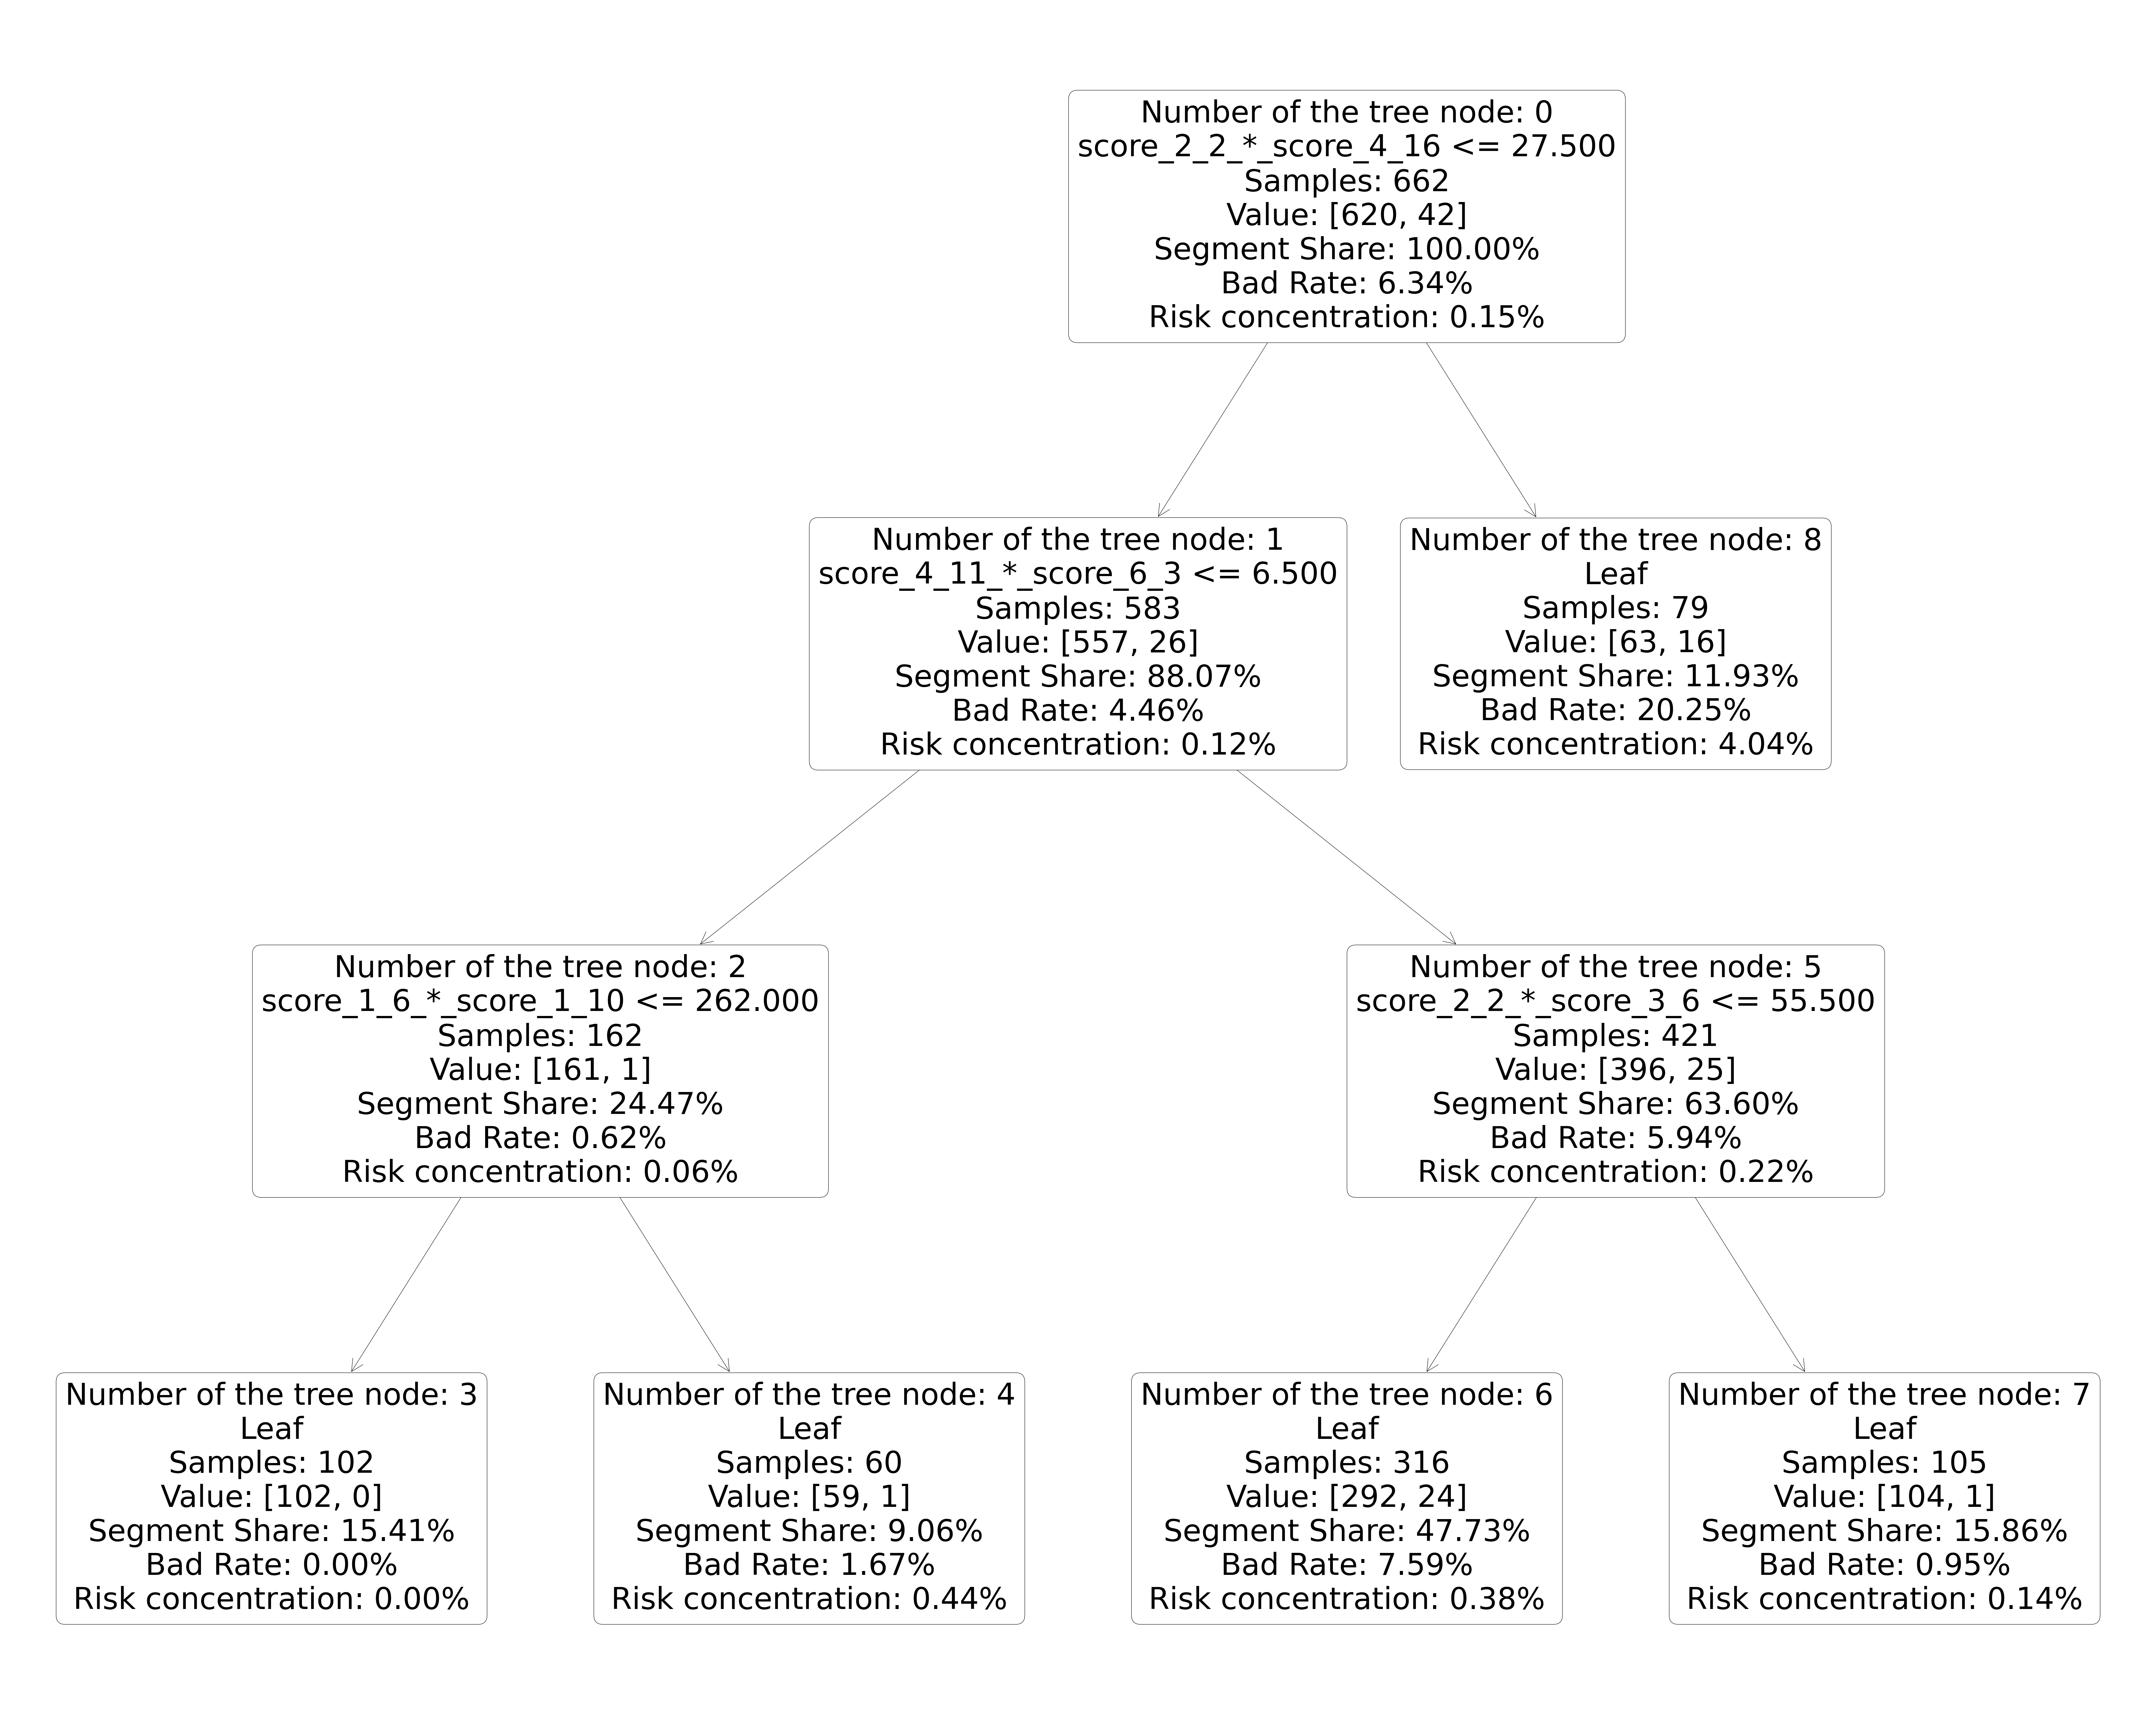

=========== Посмотрим на данные в листьях ===========
Leaf Information:
     Leaf  Samples  Bad Rate      Value
0  Leaf 3      102  0.000000   [102, 0]
1  Leaf 4       60  0.016667    [59, 1]
2  Leaf 6      316  0.075949  [292, 24]
3  Leaf 7      105  0.009524   [104, 1]
4  Leaf 8       79  0.202532   [63, 16]

=========== Что будет если исключить наш 'лист' из всех данных ===========
Leaf Information:
     Leaf  Remaining Samples  Remaining Bad Rate Remaining Value
0  Leaf 3                560            0.075000       [518, 42]
1  Leaf 4                602            0.068106       [561, 41]
2  Leaf 6                346            0.052023       [328, 18]
3  Leaf 7                557            0.073609       [516, 41]
4  Leaf 8                583            0.044597       [557, 26]


In [30]:
clf_tree = visualize_decision_trees(df, vars, TARGET, num_forests=1,
                            min_samples_leaf=60, max_depth=3, percent_feat=1,
                            pic_name='result_rules/example_tree_structure_0_v',
                            show_image=True, full_info=True)

### Как вывести обьекты из конкретного листка дерева имея только дерево на руках

In [43]:
def get_objects_in_leaf(df, clf_tree, leaf_number):
    """
    Получает объекты, находящиеся в указанном листе дерева.

    Параметры:
        - df (DataFrame): Исходный DataFrame, содержащий данные.
        - clf_tree (DecisionTreeClassifier): Обученный классификатор дерева решений.
        - leaf_number (int): Номер листа дерева, для которого нужно получить объекты.

    Возвращает:
        DataFrame: Подмножество DataFrame, содержащее объекты, находящиеся в указанном листе.

    """
    leaf_indices = clf_tree.apply(df[vars]) == leaf_number  # Получение индексов объектов, принадлежащих листу
    leaf_objects = df.loc[leaf_indices]  # Получение подмножества DataFrame с объектами листа
    return leaf_objects

# Пример использования
leaf_number = 8  # Номер листа, для которого вы хотите получить объекты
objects_in_leaf = get_objects_in_leaf(df, clf_tree[0], leaf_number)
objects_in_leaf


,credit_id,date_requested,npl1_1_7dpd,reapeted_app,reapeted_app_1w,reapeted_app_1m,reapeted_app_3m,reapeted_app_6m,credits_active_owner,credits_all_owner,...,score_8_1_division_mail_score_round,score_8_2_*_score_8_2,score_8_2_*_score_8_3,score_8_2_division_score_8_3,score_8_2_*_mail_score_round,score_8_2_division_mail_score_round,score_8_3_*_score_8_3,score_8_3_*_mail_score_round,score_8_3_division_mail_score_round,target
5090,4126022,2022-11-02 12:39:39,0,2,1,1,1,2,6.0,12.0,...,12.032086,49.0,7.0,7.0,5.236,9.358289,1.0,0.748,1.336898,0
5092,4126220,2022-11-02 13:15:47,0,0,0,0,0,0,3.0,10.0,...,13.953488,36.0,6.0,6.0,3.870,9.302326,1.0,0.645,1.550388,0
5109,4131480,2022-11-04 09:27:33,0,10,0,0,3,3,5.0,10.0,...,inf,36.0,18.0,2.0,0.000,inf,9.0,0.000,inf,0
5112,4131699,2022-11-04 10:43:53,0,0,0,0,0,0,6.0,12.0,...,16.077170,49.0,7.0,7.0,4.354,11.254019,1.0,0.622,1.607717,0
5130,4135312,2022-11-05 15:14:06,1,6,0,2,6,6,8.0,23.0,...,15.174507,49.0,7.0,7.0,4.613,10.622155,1.0,0.659,1.517451,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5706,4550368,2023-04-12 17:34:48,0,2,0,0,0,0,2.0,8.0,...,10.071942,36.0,6.0,6.0,4.170,8.633094,1.0,0.695,1.438849,0
5712,4551340,2023-04-13 09:50:16,0,1,0,0,0,0,1.0,17.0,...,14.802632,1.0,1.0,1.0,0.608,1.644737,1.0,0.608,1.644737,0
5713,4551638,2023-04-13 11:17:28,0,4,0,0,0,0,7.0,13.0,...,13.392857,49.0,7.0,7.0,4.704,10.416667,1.0,0.672,1.488095,0
5723,4554389,2023-04-14 12:13:32,0,2,2,2,2,2,5.0,11.0,...,13.774105,49.0,7.0,7.0,5.082,9.641873,1.0,0.726,1.377410,0


Теперь leaf_objects будет содержать объекты, которые находятся в листе дерева с заданным номером leaf_number.

### Отбор новых данных используя условия дерева

In [70]:
def get_leaf_distribution(tree, X, y):
    """
    Вычисляет распределение данных по листьям дерева классификации.

    Аргументы:
    - tree: обученное дерево классификации, полученное из модели.
    - X: новые данные для прогнозирования.
    - y: соответствующие целевые значения для новых данных.

    Возвращает:
    - leaf_info_df: DataFrame с информацией о распределении данных по листьям.

    """

    # Применяем дерево к новым данным для получения индексов листьев
    leaf_indices = tree.apply(X)

    # Вычисляем количество объектов в каждом листе
    leaf_distribution = pd.Series(leaf_indices).value_counts().sort_index()

    leaf_info = []
    for leaf_number, count in leaf_distribution.items():
        # Вычисляем количество примеров в листе
        leaf_samples = count
        # Извлекаем соответствующие целевые значения для данного листа
        leaf_y = y[leaf_indices == leaf_number]
        # Вычисляем долю негативных примеров (Bad Rate) в листе
        leaf_bad_rate = sum(leaf_y) / leaf_samples
        # Вычисляем значение (Value) для листа, представляющее собой список [количество негативных примеров, количество положительных примеров]
        leaf_value = [leaf_samples - sum(leaf_y), sum(leaf_y)]
        # Вычисляем долю сегмента внутри листа (Segment Share)
        segment_share = sum(leaf_y) / len(y)
        # Вычисляем концентрацию риска (Risk Concentration) в листе, представляющую собой долю положительных примеров внутри листа
        risk_concentration = (leaf_bad_rate / sum(y)) / (leaf_samples / len(y))
        
        # Сохраняем информацию о листе в виде словаря
        leaf_info.append({
            "Leaf": f"Leaf {leaf_number}",
            "Samples": leaf_samples,
            "Bad Rate": round(leaf_bad_rate * 100, 2),
            "Segment Share": round(segment_share * 100, 2),
            "Value": leaf_value,
            "Risk Concentration in the Segment": round(risk_concentration * 100, 2)
        })

    # Преобразуем список словарей в DataFrame
    leaf_info_df = pd.DataFrame(leaf_info)

    # Возвращаем DataFrame с информацией о распределении данных по листьям
    return leaf_info_df





# Пример использования 
get_leaf_distribution(clf_tree[0], df[vars][:200], df[TARGET][:200])

,Leaf,Samples,Bad Rate,Segment Share,Value,Risk Concentration in the Segment
0,Leaf 3,33,0.00,0.0,"[33, 0]",0.00
1,Leaf 4,17,0.00,0.0,"[17, 0]",0.00
2,Leaf 6,89,8.99,4.0,"[81, 8]",1.44
3,Leaf 7,35,0.00,0.0,"[35, 0]",0.00
4,Leaf 8,26,23.08,3.0,"[20, 6]",12.68
